In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import DB
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
db = DB(db_route = '../data/database.sqlite')

In [3]:
df = db.stackFoulCardDF()

Stacking Cards:   0%|          | 0/14217 [00:00<?, ?it/s]

Stacking Fouls:   0%|          | 0/14217 [00:00<?, ?it/s]

In [7]:
# prem is 1729
#pd.merge(df, db.league[['id','name']], how = 'left', left_on = 'league_id', right_on = 'id')
#df.to_csv('../data/dummy_card_foul.csv')

In [115]:
df = pd.read_csv('../data/dummy_card_foul.csv', index_col = 'Unnamed: 0')

In [116]:
df = df.sort_values(by = 'date')

In [117]:
foul_columns = df.filter(regex = 'foul*').columns[2:]
for col in tqdm(foul_columns):
    df['home_team_%s' % col]  = df[df['fouling_team'] == df['home_team_api_id']][col]
    df['home_team_%s' % col] = df['home_team_%s' % col].fillna(0)
    df['away_team_%s' % col]  = df[df['fouling_team'] == df['away_team_api_id']][col].fillna(0)
    df['away_team_%s' % col] = df['away_team_%s' % col].fillna(0)

  0%|          | 0/13 [00:00<?, ?it/s]

In [118]:
card_columns = df.filter(regex = 'card').columns[1:]
for col in tqdm(card_columns):
    df['home_team_%s' % col] = df[df['carded_team'] == df['home_team_api_id']][col]
    df['home_team_%s' % col] = df['home_team_%s' % col].fillna(0)
    df['away_team_%s' % col] = df[df['carded_team'] == df['away_team_api_id']][col]
    df['away_team_%s' % col] = df['away_team_%s' % col].fillna(0)

  0%|          | 0/16 [00:00<?, ?it/s]

In [119]:
group_columns = list(df.columns[:8])
prep = df.drop(['carded_team', 'fouling_team'], axis = 1).groupby(by = group_columns, as_index = False).sum()

In [120]:
prep['result'] = 0

In [121]:
prep['result'][prep['home_team_goal'] > prep['away_team_goal']] = 'W'
prep['result'][prep['home_team_goal'] < prep['away_team_goal']] = 'L'
prep['result'][prep['home_team_goal'] == prep['away_team_goal']] = 'D'
prep['result']

/var/folders/cc/c6pxrx8n6wx77yf6_g8dvdw40000gn/T/ipykernel_12567/4203361254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep['result'][prep['home_team_goal'] > prep['away_team_goal']] = 'W'
/var/folders/cc/c6pxrx8n6wx77yf6_g8dvdw40000gn/T/ipykernel_12567/4203361254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep['result'][prep['home_team_goal'] < prep['away_team_goal']] = 'L'
/var/folders/cc/c6pxrx8n6wx77yf6_g8dvdw40000gn/T/ipykernel_12567/4203361254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

0       L
1       L
2       L
3       D
4       L
       ..
8165    L
8166    L
8167    W
8168    L
8169    L
Name: result, Length: 8170, dtype: object

In [122]:
prep = prep.drop(foul_columns, axis = 1).drop(card_columns, axis = 1).sort_values(by = 'date')#.to_csv('../data/prep_data.csv')

In [123]:
cols = np.array(list(prep.columns))
def index_of(col):
    return np.where(np.array(cols) == col)[0][0]

def updateElo(df, verbose = True):
    elo_all = {'match_api_id' : [], 'home_team_api_id' : [], 'away_team_api_id' : [], 'home_elo' : [], 'away_elo' : []}
    elo = {}
    for i in range(df.shape[0]):
        row = df.iloc[i]
        home = row[index_of('home_team_api_id')]
        away = row[index_of('away_team_api_id')]
        if home not in elo:
            elo[home] = 1600
        if away not in elo:
            elo[away] = 1600
        
        elo_all['match_api_id'] += [row[index_of('match_api_id')]] 
        elo_all['home_team_api_id'] += [home]
        elo_all['away_team_api_id'] += [away]
        elo_all['home_elo'] += [elo[home]]
        elo_all['away_elo'] += [elo[away]]
        
        R1 = 10**(elo[home]/400)
        R2 = 10**(elo[away]/400)
        E1 = R1 / (R1 + R2)
        E2 = R2 / (R1 + R2)
        
        result = row[index_of('result')]
        S1 = 1 if result == 'W' else (0 if result == 'L' else 0.5)
        S2 = 0 if result == 'W' else (1 if result == 'L' else 0.5)
        
        K1 = None
        if i < 30:
            K1 = 40
        elif elo[home] < 2300:
            K1 = 20
        elif elo[home] > 2300:
            K1 = 10
        
        K2 = None
        if i < 30:
            K2 = 40
        elif elo[away] < 2300:
            K2 = 20
        elif elo[away] > 2300:
            K2 = 10
        
        R1_new = np.round(elo[home] + K1 * (S1 - E1), 3)
        R2_new = np.round(elo[away] + K2 * (S2 - E2), 3)
        
        elo[home] = R1_new
        elo[away] = R2_new
        
        if verbose:
            print("\t{home} vs {away} = {result}\nHome: {R1} --> {R1n} | K = {K1}\nAway: {R2} --> {R2n} | K = {K2}\n".format(
                home = row[index_of('home_team_name')],
                away = row[index_of('away_team_name')],
                result = result,
                R1 = elo[home],
                R1n = R1_new,
                K1 = K1,
                R2 = elo[away],
                R2n = R2_new,
                K2 = K2
            ))
            print('-------------------')
    return elo, elo_all
        

In [124]:
elo, elo_all = updateElo(prep, verbose = False)

In [127]:
prem = prep[prep['league_id'] == 1729]

In [128]:
#elo_all = pd.DataFrame(elo_all)
prem = pd.merge(prem, pd.DataFrame(elo_all).drop(['home_team_api_id', 'away_team_api_id'], axis = 1), on = 'match_api_id')

In [129]:
prem.to_csv('../data/prem_data_elo.csv')

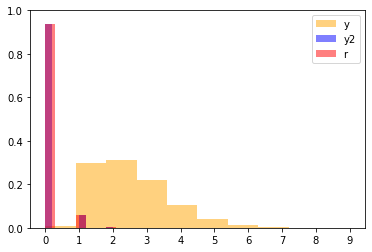

In [36]:
plt.hist(df['card_color_y'], alpha = 0.5, color = 'orange')
plt.hist(df['card_color_y2'], alpha = 0.5, color = 'blue')
plt.hist(df['card_color_r'], alpha = 0.5, color= 'red')

plt.legend(labels = ['y', 'y2', 'r'])
plt.xticks(range(10))
plt.yticks(np.linspace(0, 29560, 6), np.round(np.linspace(0, 1, 6), 2))
plt.show()

In [144]:
c, f = np.unique(prep['league_id'], return_counts = True)
lg_n = pd.DataFrame({'League' : c, 'n': f})
lg_n

,League,n
0,1729,2873
1,4769,745
2,7809,1081
3,10257,1530
4,13274,303
5,15722,7
6,19694,13
7,21518,1618


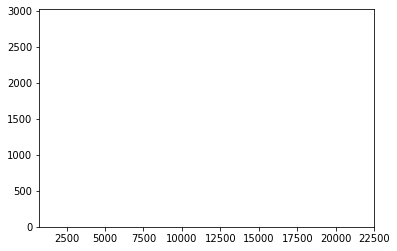

In [139]:
plt.bar(c, f, color = 'maroon')
plt.show()

In [154]:
laliga = prep[prep['league_id'] == 21518]
laliga.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_violence,home_team_card_reason_pushing,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result
443,530023,21518,2008-08-30 00:00:00,10267,Valencia CF,8661,RCD Mallorca,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
446,530090,21518,2008-08-30 00:00:00,8558,RCD Espanyol,10281,Real Valladolid,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
445,530086,21518,2008-08-31 00:00:00,8388,CD Numancia,8634,FC Barcelona,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
444,530085,21518,2008-08-31 00:00:00,9783,RC Deportivo de La Coruña,8633,Real Madrid CF,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
449,530095,21518,2008-09-13 00:00:00,8634,FC Barcelona,8696,Racing Santander,1,4,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,L


In [153]:
lg = db.league[['id', 'name']]
pd.merge(lg, lg_n, left_on = 'id', right_on = 'League').drop(['id'], axis=1).sort_values(by = 'n', ascending = False).reset_index(drop = True)

,name,League,n
0,England Premier League,1729,2873
1,Spain LIGA BBVA,21518,1618
2,Italy Serie A,10257,1530
3,Germany 1. Bundesliga,7809,1081
4,France Ligue 1,4769,745
5,Netherlands Eredivisie,13274,303
6,Scotland Premier League,19694,13
7,Poland Ekstraklasa,15722,7


In [155]:
#elo_all = pd.DataFrame(elo_all)
laliga = pd.merge(laliga, pd.DataFrame(elo_all).drop(['home_team_api_id', 'away_team_api_id'], axis = 1), on = 'match_api_id')
laliga.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,530023,21518,2008-08-30 00:00:00,10267,Valencia CF,8661,RCD Mallorca,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
1,530090,21518,2008-08-30 00:00:00,8558,RCD Espanyol,10281,Real Valladolid,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
2,530086,21518,2008-08-31 00:00:00,8388,CD Numancia,8634,FC Barcelona,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
3,530085,21518,2008-08-31 00:00:00,9783,RC Deportivo de La Coruña,8633,Real Madrid CF,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,530095,21518,2008-09-13 00:00:00,8634,FC Barcelona,8696,Racing Santander,1,4,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,L,1590.0,1600.0


In [158]:
laliga.to_csv('../data/laliga_data_elo.csv')